## Install and import libraries

In [1]:
# !pip install numpy --upgrade
!pip install mahotas

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import math

from skimage import feature
from numpy.lib import stride_tricks
import progressbar

import mahotas as mt
import cv2
from sklearn.svm import SVC

data,info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOW5PP9/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteOW5PP9/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


## Read dataset

In [5]:
train_smaples = 20
test_smaples = 4

x_train, y_train = [], []
for x in data['train'].take(train_smaples):
  x_train.append( tf.image.resize(x['image'],(128,128)) )
  y_train.append( tf.image.resize(x['segmentation_mask'],(128,128)) )

x_test, y_test = [], []
for x in data['test'].take(test_smaples):
  x_test.append( tf.image.resize(x['image'],(128,128)) )
  y_test.append( tf.image.resize(x['segmentation_mask'],(128,128)) )

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

# masks must contain only 1 or 2 (remove boarders)
y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_train[y_train==3] = 2
y_test[y_test==3] = 2

print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_test  : {x_test.shape}')
print(f'y_test  : {y_test.shape}')

x_train : (20, 128, 128, 3)
y_train : (20, 128, 128, 1)
x_test  : (4, 128, 128, 3)
y_test  : (4, 128, 128, 1)


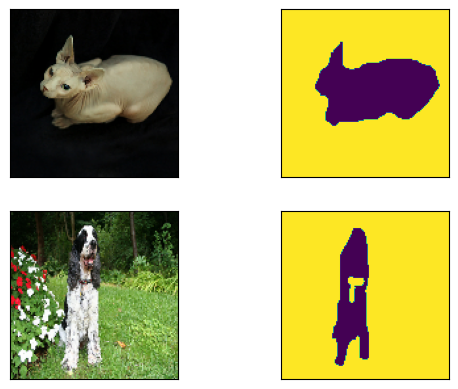

In [6]:
f, ax = plt.subplots(2,2)
ax[0,0].imshow(x_train[0].astype(np.uint8))
ax[0,1].imshow(y_train[0].astype(np.uint8))
ax[1,0].imshow(x_train[1].astype(np.uint8))
ax[1,1].imshow(y_train[1].astype(np.uint8))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()

## Extract Features

#### Defining functions

In [7]:
from skimage import feature
from numpy.lib import stride_tricks
import mahotas as mt
import numpy as np
import progressbar


# 2.  Local Binary Pattern
def LBP(img, points, radius):
    '''
     points: Number of circularly symmetric neighbour set points
     radius: Radius of circle
    '''
    lbp = feature.local_binary_pattern(img, points, radius)
    return (lbp - np.min(lbp)) / (np.max(lbp) - np.min(lbp)) * 255


# 3. Haralick's texture features
def HTF(img, h_neighbors, ss_idx):
    size = h_neighbors
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    # should be equal to the size of feature_img = feature_img[h_index:-h_index, h_index:-h_index]
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
    patches = patches.reshape(-1, size, size)

    if len(ss_idx) == 0:
        bar = progressbar.ProgressBar(maxval=len(patches),
                                      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    else:
        bar = progressbar.ProgressBar(maxval=len(ss_idx),
                                      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

    def calculate_haralick(img):
        '''
        calculate haralick features for each patch
        '''
        features = []

        feature_ = mt.features.haralick(img)
        mean_ = feature_.mean(axis=0)

        [features.append(i) for i in mean_[0:9]]

        return np.array(features)

    bar.start()
    h_features = []

    if len(ss_idx) == 0:
        for i, p in enumerate(patches):
            bar.update(i + 1)
            h_features.append(calculate_haralick(p))
    else:
        for i, p in enumerate(patches[ss_idx]):
            bar.update(i + 1)
            h_features.append(calculate_haralick(p))

    return np.array(h_features)


def extract_features(img, img_gary, label, train, lbp_radius=10, lbp_points_ratio=4, h_neighbors=11, num_examples=1000):
    '''
    extract above 13 features
    '''

    # 1.  RGB values have beed extracted when loading the orignal dataset

    # 4. extracting all the features
    # Hyperparameters:
    # lbp_radius = 10 # local binary pattern neighbourhood
    lbp_points = lbp_radius * lbp_points_ratio  # number of circularly symmetric neighbour set points
    # h_neighbors = 11 # haralick neighbourhood

    # num_examples = 1000 # number of examples (pixels) per image to use for training model
    h_index = int((h_neighbors - 1) / 2)

    feature_img = np.zeros((img.shape[0], img.shape[1], 4))
    feature_img[:, :, :3] = img
    feature_img[:, :, 3] = LBP(img_gary, lbp_points, lbp_radius)
    feature_img = feature_img[h_index:-h_index, h_index:-h_index]
    s = feature_img.shape
    features = feature_img.reshape((s[0] * s[1], s[2]))

    if train:
        ss_idx = np.random.randint(0, features.shape[0], num_examples)
        features = features[ss_idx]
    else:
        ss_idx = []

    h_features = HTF(img_gary, h_neighbors, ss_idx)
    features = np.hstack((features, h_features))

    if train:
        label = label[h_index:-h_index, h_index:-h_index]
        labels = label.reshape(label.shape[0] * label.shape[1], 1)
        labels = labels[ss_idx]
    else:
        labels = None

    return features, labels

#### Run feature extraction

In [8]:
x_train_features = []
y_train_labels = []

for i in range(train_smaples):
  img = x_train[i]
  lbl = y_train[i]
  gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_scale = gray_scale.astype('int')
  features, labels = extract_features(img, gray_scale, lbl, train = True)
  x_train_features.append(features)
  y_train_labels.append(labels)

# flatting x_train_features
x_train_features = np.array(x_train_features)
s = x_train_features.shape
x_train_features = x_train_features.reshape((s[0]*s[1],s[2]))

# flatting y_train_labels
y_train_labels = np.array(y_train_labels)
s = y_train_labels.shape
y_train_labels = y_train_labels.reshape((s[0]*s[1],s[2]))
y_train_labels = y_train_labels.ravel()
y_train_labels[y_train_labels==255] =1

print(f'\n x_train_features : {x_train_features.shape}')
print(f' y_train_labels   : {y_train_labels.shape}')

[========================================================================] 100%


 x_train_features : (20000, 13)
 y_train_labels   : (20000,)


In [ ]:
x_test_features = []

for i in range(test_smaples):
  img = x_test[i]
  gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray_scale = gray_scale.astype('int')
  features, _ = extract_features(img, gray_scale, None, train = False)
  x_test_features.append(features)

x_test_features = np.array(x_test_features)
print(f'\n x_test_features  : {x_test_features.shape}')

[==================================================================      ]  92%

## Apply SVM classifier on extracted features

In [10]:
model = SVC(kernel = 'rbf')

model.fit(x_train_features, y_train_labels.astype('int'))

SVC()

In [11]:
y_pred_labels = []

for i in range(test_smaples):
  pred_img = model.predict(x_test_features[i])

  size_pred = int(math.sqrt(pred_img.shape[0]))
  pred_img = pred_img.reshape(size_pred, size_pred, 1)
  y_pred_labels.append(pred_img)

y_pred_labels = np.array(y_pred_labels)
print(f'y_pred_labels  : {y_pred_labels.shape}')

y_pred_labels  : (4, 118, 118, 1)


## Showing result

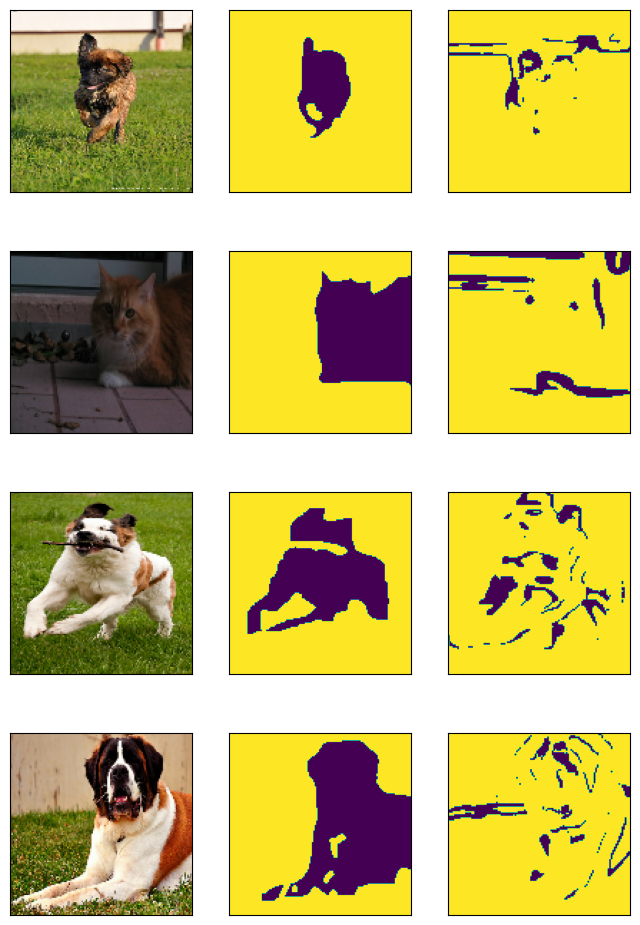

In [12]:
import math

f, ax = plt.subplots(test_smaples,3, figsize=(8, 12))

for i in range(test_smaples):
  ax[i,0].imshow(x_test[i].astype(np.uint8))
  ax[i,1].imshow(y_test[i].astype(np.uint8))
  ax[i,2].imshow(y_pred_labels[i].astype(np.uint8))

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.show()